In [56]:
import pandas as pd
import numpy as np

In [57]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS

In [58]:
import matplotlib.pyplot as plt

def visualize(x, y, labels=None):
    plt.figure(figsize=(15, 5))
    plt.scatter(x, y, c=labels, cmap="tab20" if labels is not None else None)
    plt.colorbar()
    plt.show()

In [85]:
wine = pd.read_csv("data/winequality-red.csv")
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [86]:
labels = wine["quality"].to_numpy()
"Labels", len(np.unique(labels))

('Labels', 6)

In [87]:
cols_standard = ["density", "pH"]

In [88]:
def minmax(column):
    return (column - column.min()) / (column.max() - column.min())

def standartization(column):
    return (column - column.mean()) / column.std()

mat = wine.drop(labels=["quality"], axis=1).apply(lambda col: standartization(col) if col.name in cols_standard else minmax(col)).to_numpy()

### Reduce dimensions

UMAP

Original labels

Labels count: 6


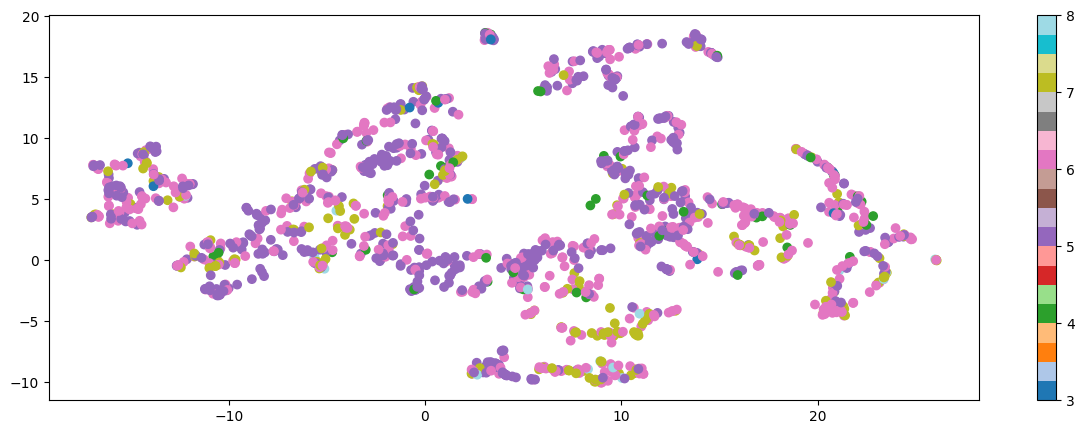

In [98]:
from umap import UMAP

u = UMAP(n_neighbors=16, metric="euclidean", min_dist=0.01, spread=3.0)
embeds = u.fit_transform(mat)
print("Labels count:", len(np.unique(labels)))
visualize(embeds[:, 0], embeds[:, 1], labels=labels)

### Clusterization

KMeans, DBSCAN, OPTICS

Clusters count: 6


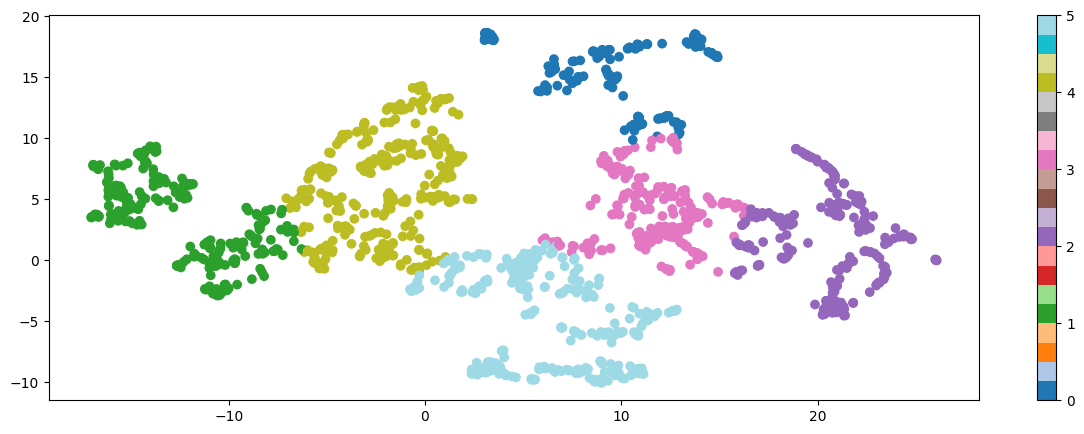

In [99]:
km = KMeans(n_clusters=6, n_init=10)
labels1 = km.fit_predict(embeds)
print("Clusters count:", len(np.unique(labels1)))
visualize(embeds[:, 0], embeds[:, 1], labels=labels1)

Clusters count: 6


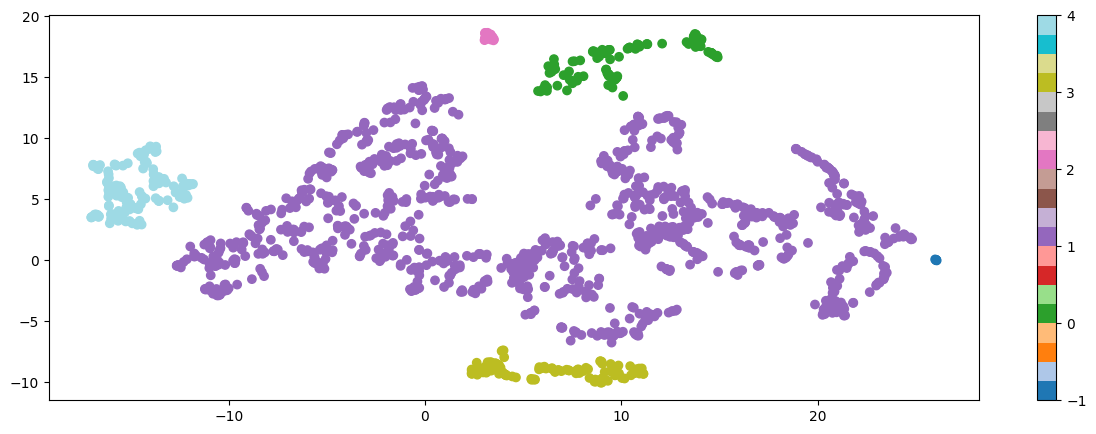

In [128]:
dbs = DBSCAN(eps=1.6, min_samples=10)
labels2 = dbs.fit_predict(embeds)
print("Clusters count:", len(np.unique(labels2)))
visualize(embeds[:, 0], embeds[:, 1], labels=labels2)

Clusters count: 6


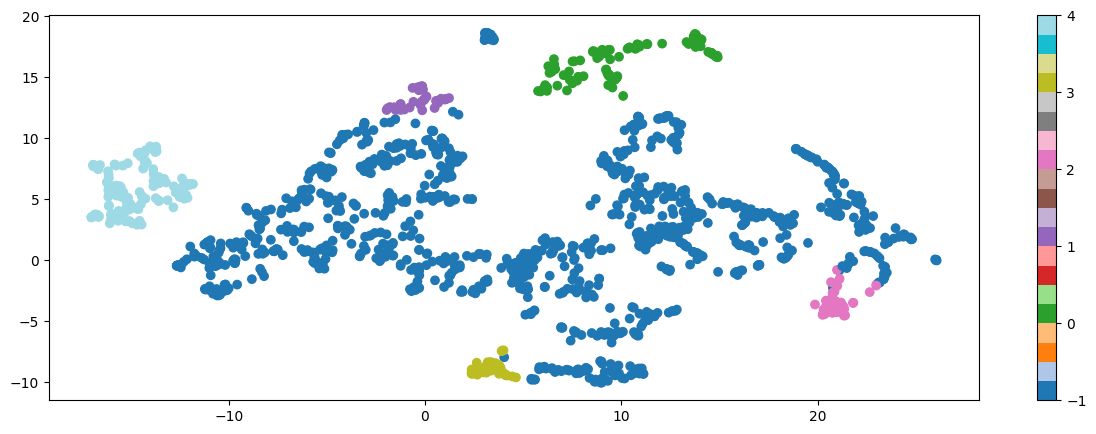

In [159]:
opt = OPTICS(min_samples=35, xi=0.1)
labels3 = opt.fit_predict(embeds)
print("Clusters count:", len(np.unique(labels3)))
visualize(embeds[:, 0], embeds[:, 1], labels=labels3)

### Сlusterization performance evaluation

https://neerc.ifmo.ru/wiki/index.php?title=Оценка_качества_в_задаче_кластеризации

#### Outer (with external labels) - Rand score

Perfect labeling is scored 1.0

Poorly agreeing labels (e.g. independent labelings) have lower scores, for the Rand index the score will be close to zero.

#### Inner (no external info) - Davies–Bouldin score

Zero is the lowest possible score. Values closer to zero indicate a better partition.

The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCAN.

In [160]:
import sklearn.metrics as metrics

In [161]:
def eval_metrics(labels_pred):
    return metrics.rand_score(labels, labels_pred), metrics.davies_bouldin_score(embeds, labels_pred)

In [162]:
# k-means
eval_metrics(labels1)

(0.59665419798513, 0.7586559443832303)

In [163]:
# dbscan
eval_metrics(labels2)

(0.4738905182447415, 0.7952582352632077)

In [164]:
# optics
eval_metrics(labels3)

(0.4658645383026469, 0.8170746578608384)

In [165]:
def annotate_plot(ax, xs, ys):
    for x, y in zip(xs, ys):
        ax.annotate(
            "{:.2f}".format(y),
            (x, y),
            textcoords="offset points",
            xytext=(0, -15),
            ha='center'
        )

In [166]:
def scores_plot(x, y1, y2):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].set_title("Rand score")
    axes[1].set_title("David-Bouldin score")
    axes[0].plot(x, y1)
    axes[1].plot(x, y2)
    annotate_plot(axes[0], x, y1)
    annotate_plot(axes[1], x, y2)

K-Means

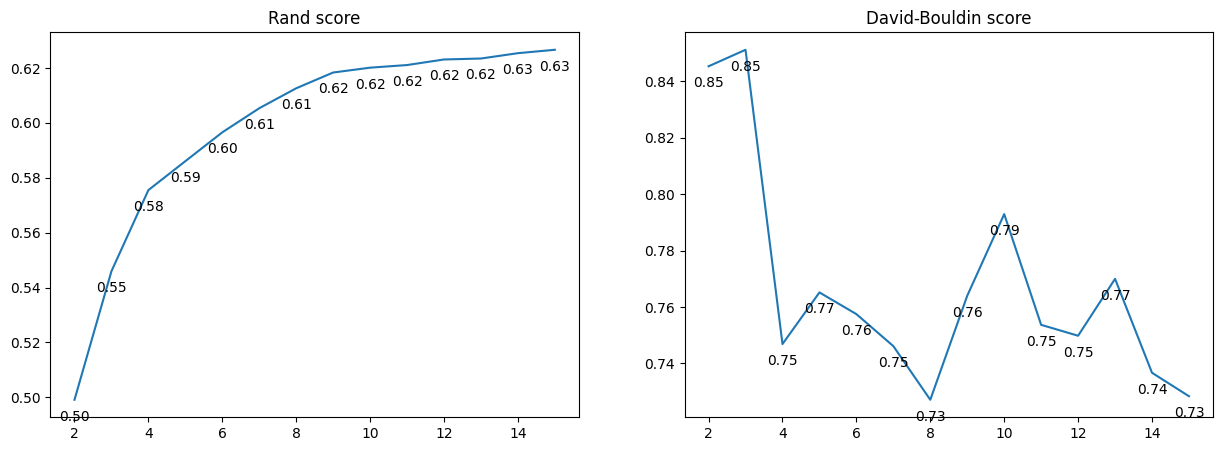

In [167]:
hist_x = list(range(2, 16))
hist_y1 = []
hist_y2 = []

for n_clusters in hist_x:
    km = KMeans(n_clusters=n_clusters, n_init=10)
    labels_ = km.fit_predict(embeds)
    y1, y2 = eval_metrics(labels_)
    hist_y1.append(y1)
    hist_y2.append(y2)

scores_plot(hist_x, hist_y1, hist_y2)

DBSCAN

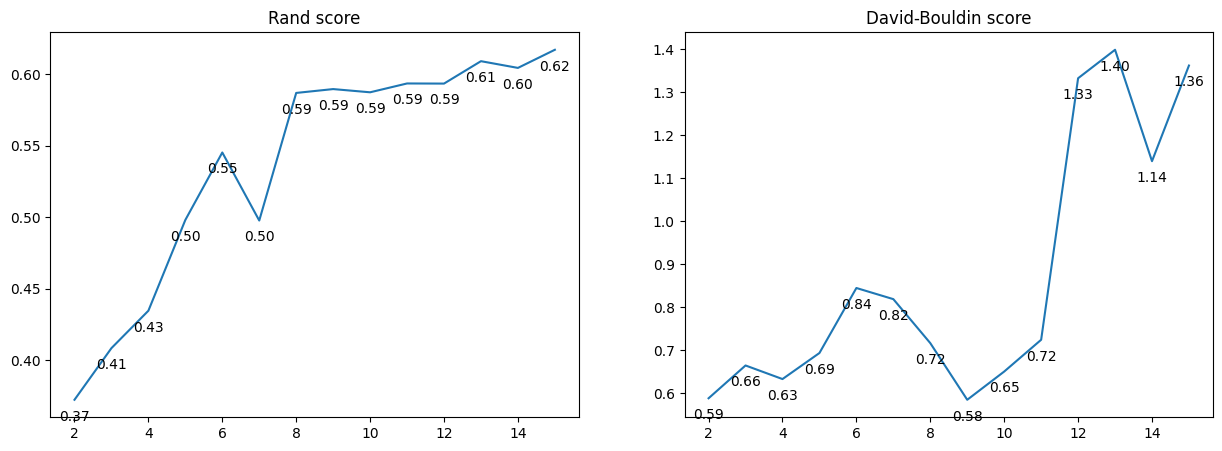

In [169]:
hist_x = list(range(2, 16))
hist_y1 = {}
hist_y2 = {}

for eps in np.linspace(1e-3, 10):
    for min_samples in np.arange(1, 30):
        dbs = DBSCAN(eps=eps, min_samples=min_samples)
        labels_ = dbs.fit_predict(embeds)
        labels_count = len(np.unique(labels_))
        if labels_count == 1 or labels_count == embeds.shape[0]:
            continue
        y1, y2 = eval_metrics(labels_)
        
        if hist_y1.get(labels_count, -1e9) < y1:
            hist_y1[labels_count] = y1
        if hist_y2.get(labels_count, 1e9) > y2:
            hist_y2[labels_count] = y2

scores_plot(hist_x, [hist_y1.get(i, np.Inf) for i in hist_x], [hist_y2.get(i, np.Inf) for i in hist_x])

OPTICS

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_optics.py:934: RuntimeWarning: divide by zero encountered in scalar divide
  steep_downward = ratio >= 1 / xi_complement
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_optics.py:840: RuntimeWarning: invalid value encountered in scalar multiply
  sda for sda in sdas if mib <= reachability_plot[sda["start"]] * xi_complement
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_optics.py:934: RuntimeWarning: divide by zero encountered in scalar divide
  steep_downward = ratio >= 1 / xi_complement
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_optics.py:840: RuntimeWarning: invalid value encountered in scalar multiply
  sda for sda in sdas if mib <= reachability_plot[sda["start"]] * xi_complement
/Library/Frameworks/Python.framework/Versions/3.11/lib/pyt

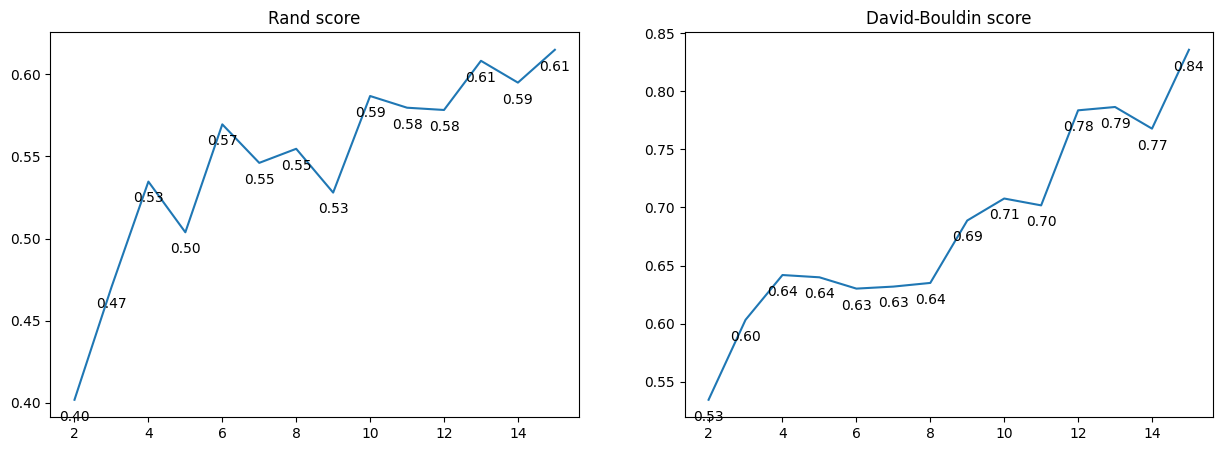

In [170]:
hist_x = list(range(2, 16))
hist_y1 = {}
hist_y2 = {}

for xi in np.linspace(1e-2, 1):
    for min_samples in np.arange(2, 50):
        opt = OPTICS(xi=xi, min_samples=min_samples)
        labels_ = opt.fit_predict(embeds)
        labels_count = len(np.unique(labels_))
        if labels_count == 1 or labels_count == embeds.shape[0]:
            continue
        y1, y2 = eval_metrics(labels_)
        
        if hist_y1.get(labels_count, -1e9) < y1:
            hist_y1[labels_count] = y1
        if hist_y2.get(labels_count, 1e9) > y2:
            hist_y2[labels_count] = y2

scores_plot(hist_x, [hist_y1.get(i, np.Inf) for i in hist_x], [hist_y2.get(i, np.Inf) for i in hist_x])

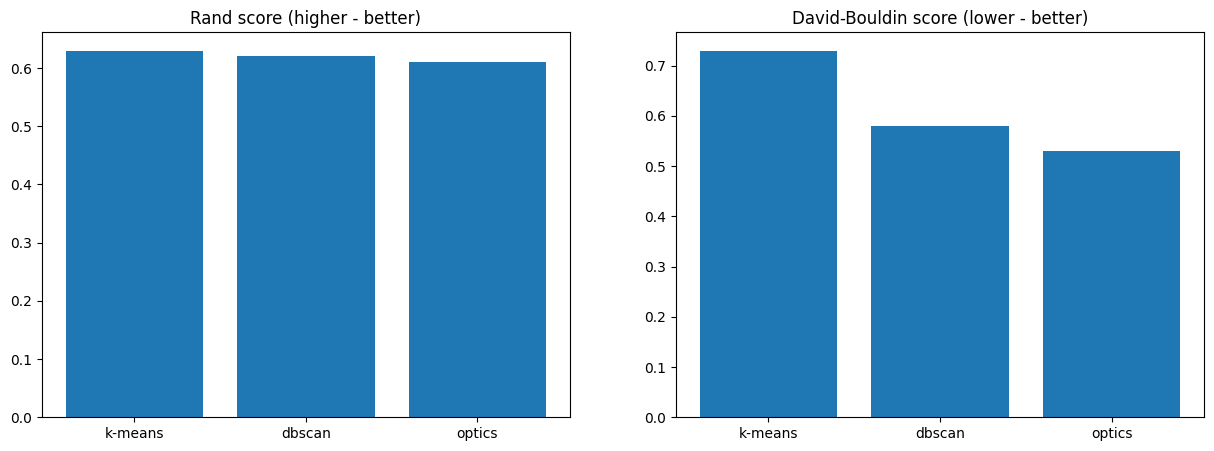

In [173]:
algorithms = ["k-means", "dbscan", "optics"]
best_y1 = [0.63, 0.62, 0.61]
best_y2 = [0.73, 0.58, 0.53]

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title("Rand score (higher - better)")
axes[1].set_title("David-Bouldin score (lower - better)")
axes[0].bar(algorithms, best_y1)
axes[1].bar(algorithms, best_y2);

Density-based algorithms have opposite scores behavior - better rand score leads to worse db-score and vice-versa.